# Image Generation via Generative Adversarial Networks

## import libraries

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os

## load data

In [2]:
directory_data  = './'
filename_data   = 'assignment_12_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))
real            = data['real_images']

In [3]:
print('size of real data:', real.shape)

size of real data: (4324, 32, 32)


## plot data

In [4]:
def plot_image(title, image):
    
    nRow = 3
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)
   
    for r in range(nRow): 
        for c in range(nCol):
            k = c * 300 + r * nCol * 300
            axes[r, c].imshow(image[k], cmap='gray')

    plt.tight_layout()
    plt.show()

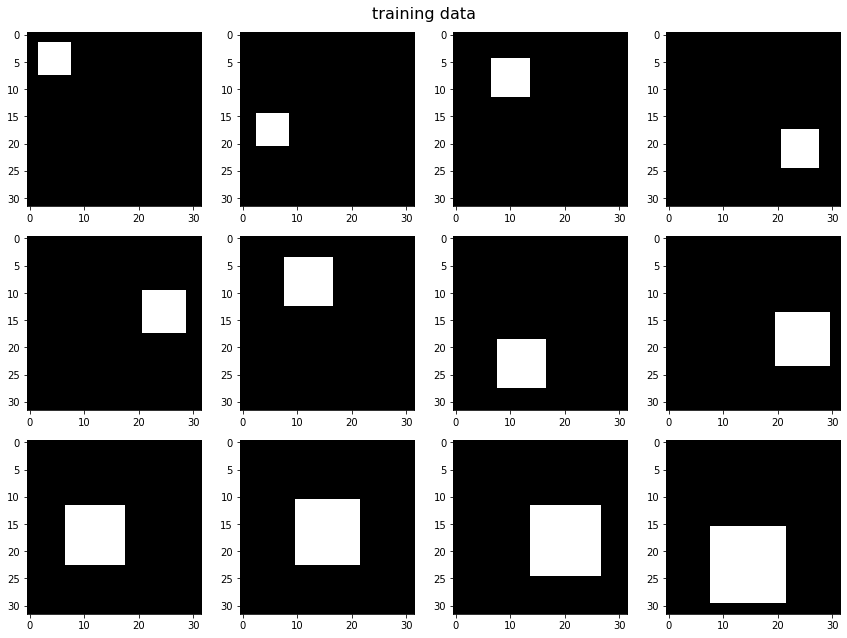

In [5]:
plot_image('training data', real)

## custom data loader for the PyTorch framework

In [6]:
class dataset(Dataset):
    
    def __init__(self, image):
        
        self.image = image
    
    def __getitem__(self, index):
        
        sample  = self.image[index]
        sample  = torch.FloatTensor(sample).unsqueeze(dim=0)

        return (sample)
    
    def __len__(self):

        number_image = len(self.image)

        return (number_image)

## setting device

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [8]:
print(device)

cuda


In [9]:
# random seed
import random
random.seed(20184757)
np.random.seed(20184757)
torch.manual_seed(20184757)
torch.cuda.manual_seed(20184757)
torch.cuda.manual_seed_all(20184757)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## construct datasets and dataloaders 

In [10]:
size_minibatch  = 32
dim_latent      = 64 # input latent vector fixed dimension 

dataset_real    = dataset(real)
dataloader_real = torch.utils.data.DataLoader(dataset_real, batch_size=size_minibatch, shuffle=True, drop_last=True)

## neural networks 

In [11]:
class Discriminator(nn.Module): 
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(256, 32),
            nn.LeakyReLU(0.2),
#             nn.Linear(64, 32),
#             nn.LeakyReLU(0.2),
#             nn.Linear(32, 16),
#             nn.LeakyReLU(0.2),
#             nn.Linear(16, 8),
#             nn.LeakyReLU(0.2),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        out = self.conv(x)
        out = nn.Flatten()(out)
        out = self.fc(out)
        
        return out


In [12]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=dim_latent, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
            
            nn.Sigmoid()
        )
    
    def forward(self, x):

        out = self.conv(x)
        
        return out

## build network

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 1.)
    elif classname.find("BatchNorm") != -1:
        nn.init.constant_(m.weight, 1.)
        nn.init.constant_(m.bias, 1.)
    elif classname.find("Linear") != -1:
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 1.)

In [14]:
generator       = Generator().to(device)
discriminator   = Discriminator().to(device)

generator = generator.apply(weights_init)
discriminator = discriminator.apply(weights_init)

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))

## compute the prediction

In [15]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the accuracy

In [16]:
def compute_bounding_mask(prediction_binary):
    
    bounding_mask = torch.zeros_like(prediction_binary)
    
    for i in range(prediction_binary.shape[0]):
        prediction = prediction_binary[i]
        (idx_row, idx_col) = torch.nonzero(prediction, as_tuple=True)
        
        if len(idx_row) > 0: 
            idx_row_min = idx_row.min()
            idx_row_max = idx_row.max()
        
            idx_col_min = idx_col.min()
            idx_col_max = idx_col.max()
    
            bounding_mask[i, idx_row_min:idx_row_max+1, idx_col_min:idx_col_max+1] = 1 
    
    return bounding_mask

In [17]:
def compute_accuracy(prediction):

    binary      = (prediction >= 0.5)
    mask        = compute_bounding_mask(binary)
    
    intersection = (binary & mask).float().sum((1, 2))
    union        = (binary | mask).float().sum((1, 2))

    eps         = 1e-8
    correct     = (intersection + eps) / (union + eps)
    accuracy    = correct.mean() * 100.0
    accuracy    = accuracy.cpu() 
    
    return accuracy

## train

In [18]:
def train(generator, discriminator, dataloader):
    
    loss_generator_epoch = []
    loss_discriminator_epoch = []
    
    for index_batch, (real) in enumerate(dataloader):
        real        = real.to(device)
        size_batch  = len(real)
        latent      = torch.randn(size_batch, dim_latent, device=device)
        latent      = torch.reshape(latent, [size_batch, dim_latent, 1, 1])

        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()
        
        optimizer_generator.zero_grad()
        fake = compute_prediction(generator, latent)
        prediction_fake = compute_prediction(discriminator, fake)
        label_fake = torch.ones_like(prediction_fake)
        loss_label = nn.BCEWithLogitsLoss()(prediction_fake, label_fake)
        loss_generator = loss_label
        loss_generator.backward()
        optimizer_generator.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()
        
        optimizer_discriminator.zero_grad()
        fake = compute_prediction(generator, latent)
        prediction_real = compute_prediction(discriminator, real)
        prediction_fake = compute_prediction(discriminator, fake)
        loss_real = nn.BCEWithLogitsLoss()(prediction_real, torch.ones_like(prediction_real, device=device))
        loss_fake = nn.BCEWithLogitsLoss()(prediction_fake, torch.zeros_like(prediction_fake, device=device))
        loss_discriminator = (loss_real + loss_fake) / 2.
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        loss_generator_epoch.append(loss_generator.item())
        loss_discriminator_epoch.append(loss_discriminator.item())
    
    return np.mean(loss_generator_epoch), np.mean(loss_discriminator_epoch)

## test

In [19]:
def test(generator, latent):
    
    generator.eval()
    
    prediction  = generator(latent)
    prediction  = prediction.squeeze(axis=1)
    accuracy    = compute_accuracy(prediction)
    
    return accuracy

## training epoch

In [20]:
number_epoch    = 2000
accuracy_epoch  = np.zeros(number_epoch)
loss_generator = np.zeros(number_epoch)
loss_discriminator = np.zeros(number_epoch)

num_latent_test = 100
latent_test = torch.randn(num_latent_test, dim_latent, device=device)
latent_test = torch.reshape(latent_test, [num_latent_test, dim_latent, 1, 1])

for i in range(number_epoch):
    loss_generator_epoch, loss_discriminator_epoch = train(generator, discriminator, dataloader_real)
    accuracy = test(generator, latent_test)
    accuracy_epoch[i] = accuracy
    
    loss_generator[i] = loss_generator_epoch
    loss_discriminator[i] = loss_discriminator_epoch
    print(f'epoch {i}, loss_generator = {loss_generator_epoch}, loss_discriminator={loss_discriminator_epoch}, accuracy={accuracy}')
    
    # if accuracy>98 stop
    if i>10 and accuracy>98:
        accuracy_epoch = accuracy_epoch[:i+1]
        break

epoch 0, loss_generator = 0.8082629900839594, loss_discriminator=0.7643318666352166, accuracy=84.20942687988281
epoch 1, loss_generator = 0.7027878527288084, loss_discriminator=0.6972652969536958, accuracy=87.51338958740234
epoch 2, loss_generator = 0.7522311550599557, loss_discriminator=0.7334282446790624, accuracy=91.7977294921875
epoch 3, loss_generator = 0.6983382472285518, loss_discriminator=0.6929080552524991, accuracy=90.97225189208984
epoch 4, loss_generator = 0.6983237134085761, loss_discriminator=0.6935412967646564, accuracy=92.1667251586914
epoch 5, loss_generator = 0.7589374214962676, loss_discriminator=0.7358458081881205, accuracy=100.0
epoch 6, loss_generator = 0.6913192913488105, loss_discriminator=0.6869762160159923, accuracy=89.08001708984375
epoch 7, loss_generator = 0.9522485311660501, loss_discriminator=0.6915906588236491, accuracy=93.10673522949219
epoch 8, loss_generator = 1.1243618664918122, loss_discriminator=0.5409262560032032, accuracy=80.57636260986328
epoch 

epoch 73, loss_generator = 5.623464893411707, loss_discriminator=0.24457846929629642, accuracy=90.66010284423828
epoch 74, loss_generator = 5.483881175959552, loss_discriminator=0.24715743285638314, accuracy=89.63140869140625
epoch 75, loss_generator = 9.533017230916906, loss_discriminator=0.09703522027056251, accuracy=81.46532440185547
epoch 76, loss_generator = 7.446395310649166, loss_discriminator=0.16692125524083773, accuracy=92.42424011230469
epoch 77, loss_generator = 6.684698507520888, loss_discriminator=0.19940119280859275, accuracy=90.4032974243164
epoch 78, loss_generator = 5.672221038959645, loss_discriminator=0.22358151420398995, accuracy=90.1744384765625
epoch 79, loss_generator = 5.9573861863878035, loss_discriminator=0.19885778973499935, accuracy=92.44161224365234
epoch 80, loss_generator = 5.484625477261013, loss_discriminator=0.23409820270759088, accuracy=91.92988586425781
epoch 81, loss_generator = 6.105573742477982, loss_discriminator=0.19224909612977947, accuracy=91

epoch 146, loss_generator = 7.851804099259553, loss_discriminator=0.17953876668104418, accuracy=95.08613586425781
epoch 147, loss_generator = 8.037119439796164, loss_discriminator=0.17710521579892546, accuracy=95.38240051269531
epoch 148, loss_generator = 7.81248246828715, loss_discriminator=0.1693222697686266, accuracy=94.69292449951172
epoch 149, loss_generator = 7.565987904866536, loss_discriminator=0.18877969649102952, accuracy=94.68534851074219
epoch 150, loss_generator = 7.395334569613139, loss_discriminator=0.21325461869990384, accuracy=92.91785430908203
epoch 151, loss_generator = 7.183264375616003, loss_discriminator=0.23139099953351197, accuracy=93.40728759765625
epoch 152, loss_generator = 8.022812838024564, loss_discriminator=0.2196064107671932, accuracy=91.98424530029297
epoch 153, loss_generator = 8.678346153541847, loss_discriminator=0.18483889356807426, accuracy=94.42632293701172
epoch 154, loss_generator = 8.742971664004855, loss_discriminator=0.18824310104052225, accu

epoch 219, loss_generator = 7.530733823776245, loss_discriminator=0.15804001909715157, accuracy=92.86756896972656
epoch 220, loss_generator = 7.414812480078803, loss_discriminator=0.14987978090842566, accuracy=93.14581298828125
epoch 221, loss_generator = 6.3957648577513515, loss_discriminator=0.1645632272793187, accuracy=94.60643005371094
epoch 222, loss_generator = 6.678474405076769, loss_discriminator=0.17970789753728442, accuracy=93.87796020507812
epoch 223, loss_generator = 6.380609973271688, loss_discriminator=0.18072793274014085, accuracy=94.02961730957031
epoch 224, loss_generator = 8.035922184696904, loss_discriminator=0.1486643754221775, accuracy=93.59909057617188
epoch 225, loss_generator = 7.316086505960535, loss_discriminator=0.1384681878818406, accuracy=93.67743682861328
epoch 226, loss_generator = 7.418386945018062, loss_discriminator=0.15381486846341028, accuracy=95.01079559326172
epoch 227, loss_generator = 6.574147922021371, loss_discriminator=0.16811006985328816, acc

epoch 292, loss_generator = 8.385399119059246, loss_discriminator=0.15488885745958045, accuracy=95.26023864746094
epoch 293, loss_generator = 7.334863016340468, loss_discriminator=0.17586235351584575, accuracy=94.37297058105469
epoch 294, loss_generator = 8.100342427359687, loss_discriminator=0.15121987721434346, accuracy=93.18524932861328
epoch 295, loss_generator = 8.103295658252858, loss_discriminator=0.14841014317892215, accuracy=94.19408416748047
epoch 296, loss_generator = 8.395694916336625, loss_discriminator=0.1453210491825033, accuracy=93.83897399902344
epoch 297, loss_generator = 7.930551560719808, loss_discriminator=0.1650936772150022, accuracy=92.11573791503906
epoch 298, loss_generator = 7.828068664338853, loss_discriminator=0.14656370505690575, accuracy=95.19392395019531
epoch 299, loss_generator = 7.308435155727246, loss_discriminator=0.13965974138290793, accuracy=94.56048583984375
epoch 300, loss_generator = 7.846795571291888, loss_discriminator=0.13990045963890022, acc

epoch 364, loss_generator = 14.337829317869964, loss_discriminator=0.15891700055864122, accuracy=95.5938491821289
epoch 365, loss_generator = 13.96676394144694, loss_discriminator=0.14784689934717285, accuracy=96.13935089111328
epoch 366, loss_generator = 13.275328841032806, loss_discriminator=0.16180610484271138, accuracy=96.47013854980469
epoch 367, loss_generator = 13.179203019318757, loss_discriminator=0.16066974445625587, accuracy=94.73283386230469
epoch 368, loss_generator = 13.409871871383102, loss_discriminator=0.16526424010042792, accuracy=96.20530700683594
epoch 369, loss_generator = 14.970725765934697, loss_discriminator=0.1363645130837405, accuracy=96.25362396240234
epoch 370, loss_generator = 15.001126557809336, loss_discriminator=0.12872189987036917, accuracy=95.034912109375
epoch 371, loss_generator = 14.57660267441361, loss_discriminator=0.11968365623443215, accuracy=95.61672973632812
epoch 372, loss_generator = 14.928161818892868, loss_discriminator=0.12093866301907433

epoch 436, loss_generator = 9.234907174993443, loss_discriminator=0.11981539982888434, accuracy=95.6423110961914
epoch 437, loss_generator = 9.45547728008694, loss_discriminator=0.1084246199440073, accuracy=96.67656707763672
epoch 438, loss_generator = 10.605786644970928, loss_discriminator=0.10255656856353636, accuracy=96.56919860839844
epoch 439, loss_generator = 10.430407467594852, loss_discriminator=0.09958719935406138, accuracy=96.66259002685547
epoch 440, loss_generator = 8.49193620858369, loss_discriminator=0.10700371011539742, accuracy=97.63046264648438
epoch 441, loss_generator = 8.707506003203216, loss_discriminator=0.09962157871988085, accuracy=96.463134765625
epoch 442, loss_generator = 8.22848542884544, loss_discriminator=0.09357521358739447, accuracy=96.66783905029297
epoch 443, loss_generator = 8.06623924749869, loss_discriminator=0.09965895658565892, accuracy=95.5280990600586
epoch 444, loss_generator = 8.720835777565284, loss_discriminator=0.10143446060656397, accuracy

---

# functions for presenting the results

---

In [21]:
def function_result_01():

    num_latent_visualize = 16

    latent_visualize = torch.randn(num_latent_visualize, dim_latent, device=device)
    latent_visualize = torch.reshape(latent_visualize, [num_latent_visualize, dim_latent, 1, 1]) 

    prediction = compute_prediction(generator, latent_visualize)
    prediction = prediction.squeeze(axis=1)
    prediction_binary = (prediction >= 0.5)
    bounding_mask = compute_bounding_mask(prediction_binary)
        
    fake = prediction.detach().cpu()
    mask = bounding_mask.detach().cpu()

    nRow = 4
    nCol = 4 
    size = 3 
    
    title = 'fake image'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(fake[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()
    
    title = 'bounding mask'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(mask[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)
                        
    plt.tight_layout()
    plt.show()

In [22]:
def function_result_02():

    title           = 'accuracy'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)
    
    plt.plot(accuracy_epoch)
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [23]:
def function_result_03():

    print('final accuracy = %9.8f' % (accuracy_epoch[-1]))

---

## results

---


################################################################################
#
# RESULT # 01
#
################################################################################



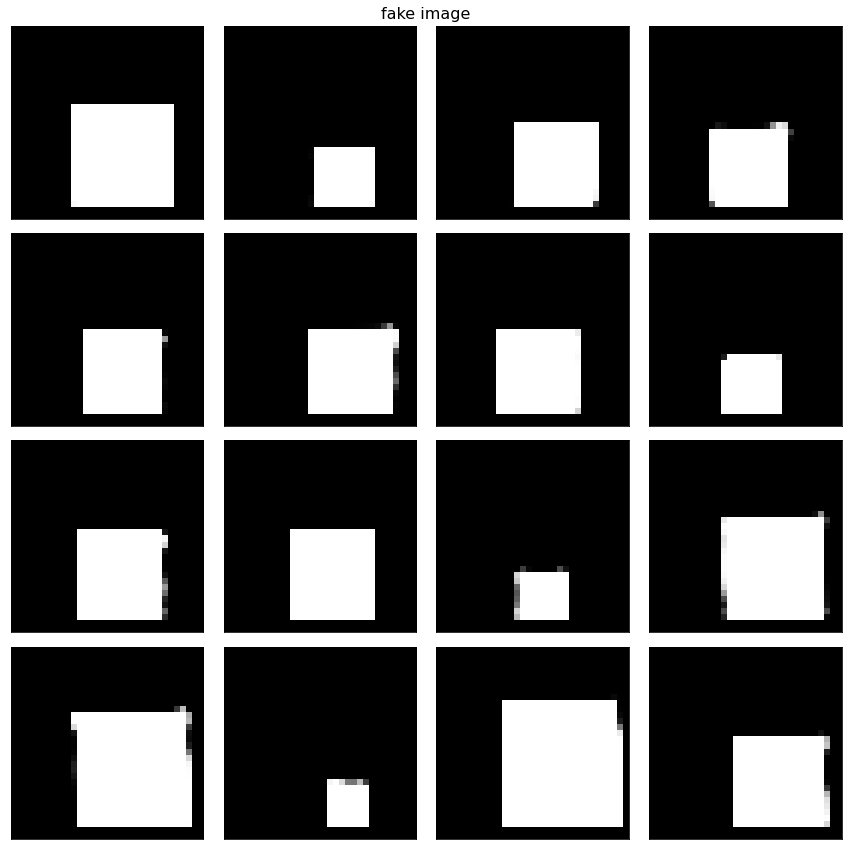

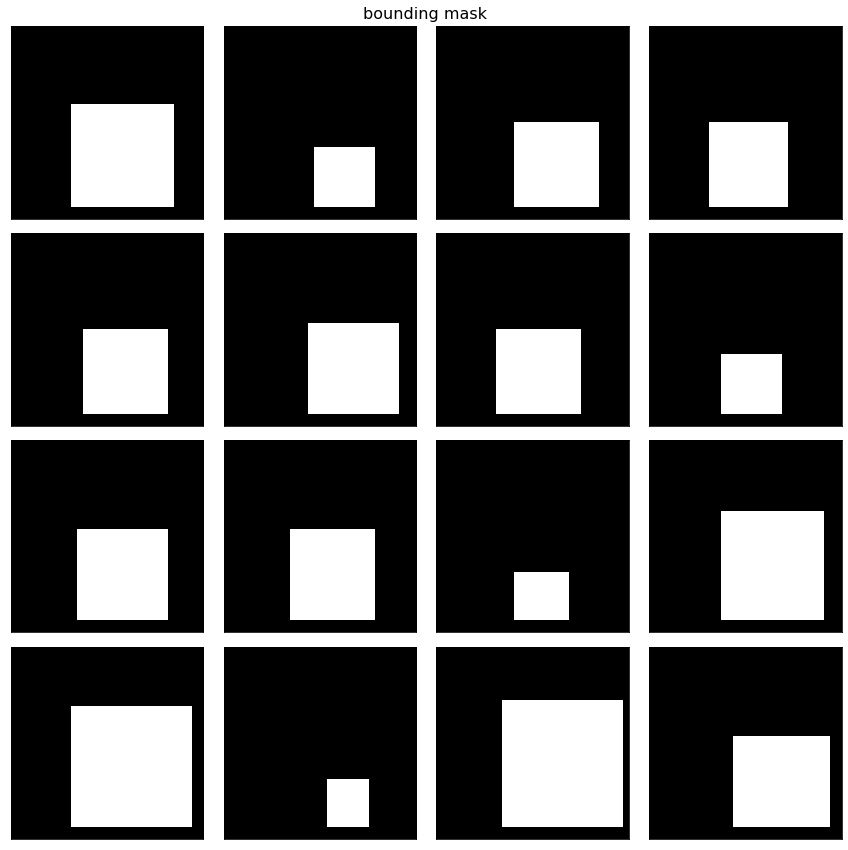


################################################################################
#
# RESULT # 02
#
################################################################################



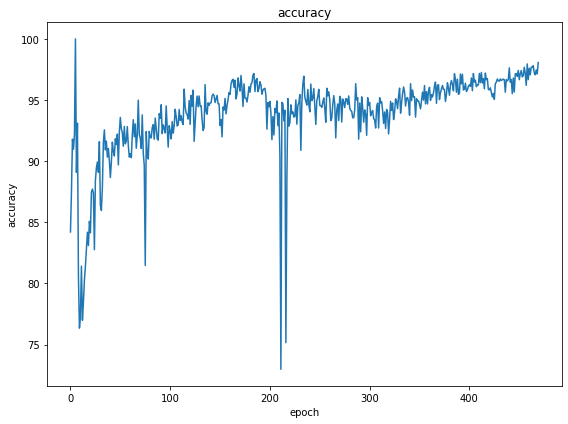


################################################################################
#
# RESULT # 03
#
################################################################################

final accuracy = 98.07032013


In [24]:
number_result = 3

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)